LÀM SẠCH DỮ LIỆU

In [1]:
import pandas as pd
import numpy as np
import math

data = pd.read_csv('C:\KHDL_CK\Data\\raw_data_train.csv')

print(data.head())

                                         name        Movement Case material  \
0                      Patek Philippe Gondolo  Manual winding   Yellow gold   
1                     Patek Philippe Nautilus       Automatic         Steel   
2           Patek Philippe Perpetual Calendar               -             -   
3  Patek Philippe Annual Calendar Chronograph       Automatic    White gold   
4                   Patek Philippe World Time       Automatic     Rose gold   

  Year of production  Condition Reference number  \
0               2010  Very good        5109J-001   
1               2020        New   7118/1200A-011   
2                  -        New            5236P   
3               2020     Unworn     5960/01G-001   
4                  -        New        7130R-014   

               Scope of delivery  \
0  Original box, original papers   
1  Original box, original papers   
2  Original box, original papers   
3  Original box, original papers   
4  Original box, original papers

In [2]:
print(data['Case material'].value_counts())

Case material
White gold     2637
Rose gold      2575
Steel          2221
Yellow gold    1573
Platinum        774
-               449
Gold/Steel      130
Red gold         42
Silver            6
Aluminum          3
Palladium         2
Name: count, dtype: int64


Làm sạch "price"

In [3]:
data['price'] = data['price'].str.replace(',', '')
data['price'] = data['price'].str.replace('$', '')

data = data.rename(columns={'price': 'price($)'})

# Chuyển đổi các giá trị trong cột 'price($)' thành số, các giá trị không phải là số sẽ thành NaN
data['price($)'] = pd.to_numeric(data['price($)'], errors='coerce')

data = data.dropna(subset=['price($)'])
data['price($)'] = data['price($)'].astype(float)  

Ở đặc trưng Case diameter thông thường sẽ mang 2 dạng giá trị là số đơn lẻ (mang ý nghĩa là đường kính mặt đồng hồ) hoặc số x số (mang ý nghĩa là chiều dài hoặc chiều rộng của 1 chiếc đồng hồ có mặt là hình chữ nhật). Ta cần thống nhất về dạng dữ liệu về dạng diện tích mặt đồng hồ (hình tròn hoặc hình chữ nhật). Ngoài ra còn có 1 số trường hợp giá trị đặc biệt ta cần phải lượt bỏ đi.

In [4]:
# Kiểm tra hàng nào có số lượng ký tự x nhiều hơn 1 thì xóa đi
data = data[data['Case diameter'].str.count('x') <= 1]

data['Case diameter'] = data['Case diameter'].str.replace('mm', '')
data['Case diameter'] = data['Case diameter'].str.replace('MM mm', '')
data['Case diameter'] = data['Case diameter'].str.replace('mm mm', '')
data['Case diameter'] = data['Case diameter'].str.replace('x', '*')
data['Case diameter'] = data['Case diameter'].str.replace(' ', '')

# Loại bỏ các giá trị không hợp lệ (không chứa chữ cái, chỉ chứa số, số thập phân và dấu '*' hoặc '-')
data = data[data['Case diameter'].str.contains(r'^[\d\.\*\-]+$')]

# Thay thế dấu phẩy bằng dấu chấm trong chuỗi giá trị
data['Case diameter'] = data['Case diameter'].str.replace(',', '.')

def calculate_area(diameter_string):
    if '*' in diameter_string:
        length, width = map(float, diameter_string.split('*'))
        area = length * width
    elif '-' in diameter_string:
        return '-'
    else:
        diameter = float(diameter_string)
        radius = diameter / 2
        area = math.pi * (radius ** 2)
    
    return area

data['Case diameter'] = data['Case diameter'].apply(calculate_area)
data = data.rename(columns={'Case diameter': 'Case area(mm2)'})

print(data[['Case area(mm2)']])


      Case area(mm2)
0         706.858347
1          973.13974
2        1339.645793
3        1288.249338
5        1075.210086
...              ...
10406    1194.590607
10407    1256.637061
10408     1385.44236
10410    1194.590607
10411              -

[8755 rows x 1 columns]


In [5]:
data.head()

,name,Movement,Case material,Year of production,Condition,Reference number,Scope of delivery,Location,Case area(mm2),price($)
0,Patek Philippe Gondolo,Manual winding,Yellow gold,2010,Very good,5109J-001,"Original box, original papers","Germany, Düsseldorf",706.858347,12238.0
1,Patek Philippe Nautilus,Automatic,Steel,2020,New,7118/1200A-011,"Original box, original papers","United States of America, New York, New York",973.13974,81860.0
2,Patek Philippe Perpetual Calendar,-,-,-,New,5236P,"Original box, original papers","United States of America, Florida, North Miami...",1339.645793,121745.0
3,Patek Philippe Annual Calendar Chronograph,Automatic,White gold,2020,Unworn,5960/01G-001,"Original box, original papers","United States of America, New York, New York",1288.249338,61445.0
5,Patek Philippe Calatrava,-,White gold,-,Very good,5117G,"Original box, no original papers","Czech Republic, Praha 1",1075.210086,21046.0


Dataset cơ bản đã được xử lý xong. Bây giờ ta cần thực hiện xử lý những giá trị bị trống hoặc không mang giá trị.

Trước hết ta cần tính số liệu về những dữ liệu bị trống.

In [6]:
# Tính tỉ lệ các dữ liệu bị thiếu
# Dữ liệu bị thiếu có thể là "-" hoặc "NaN" hoặc "None" hoặc "N/A" hoặc "na" hoặc "n/a" hoặc "null" hoặc "NULL" hoặc "nil" hoặc "NIL" hoặc là để trống
missing_data = data.isin(['-', 'NaN', 'None', 'N/A', 'na', 'n/a', 'null', 'NULL', 'nil', 'NIL', '']).sum()
total_data = data.shape[0]
missing_ratio = missing_data / total_data

print(missing_data)
print(total_data)
print(missing_ratio)

print("====================================")
total_missing = missing_data.sum()
total_cells = data.size
print("Tổng số ô dữ liệu trong file là: ", total_cells)
print("Tổng số ô dữ liệu bị thiếu trong file là: ", total_missing)
print("Tỉ lệ dữ liệu bị thiếu trong dataset là: ", (total_missing / total_cells)*100, "%")

print("====================================")

# Tính số hàng bị thiếu dữ liệu
missing_rows = data.isin(['-', 'NaN', 'None', 'N/A', 'na', 'n/a', 'null', 'NULL', 'nil', 'NIL', '']).sum(axis=1)
total_rows = data.shape[0]
missing_row_ratio = missing_rows / total_rows

print(missing_rows)
print(total_rows)
print(missing_row_ratio)




name                     0
Movement               373
Case material          397
Year of production    2817
Condition               86
Reference number       245
Scope of delivery        0
Location                 0
Case area(mm2)         685
price($)                 0
dtype: int64
8755
name                  0.000000
Movement              0.042604
Case material         0.045346
Year of production    0.321759
Condition             0.009823
Reference number      0.027984
Scope of delivery     0.000000
Location              0.000000
Case area(mm2)        0.078241
price($)              0.000000
dtype: float64
Tổng số ô dữ liệu trong file là:  87550
Tổng số ô dữ liệu bị thiếu trong file là:  4603
Tỉ lệ dữ liệu bị thiếu trong dataset là:  5.257567104511708 %
0        0
1        0
2        3
3        0
5        2
        ..
10406    0
10407    1
10408    1
10410    0
10411    1
Length: 8755, dtype: int64
8755
0        0.000000
1        0.000000
2        0.000343
3        0.000000
5        0.0

In [7]:

empty_strings = ['-', 'NaN', 'None', 'N/A', 'na', 'n/a', 'null', 'NULL', 'nil', 'NIL', ' ']

# Kiểm tra xem có hàng nào chứa chuỗi kí tự biểu thị ô dữ liệu trống không
empty_rows = data.apply(lambda row: row.astype(str).isin(empty_strings).any(), axis=1)

num_empty_rows = empty_rows.sum()

print("Tổng số hàng trong dataset là:", total_rows)
print("Số hàng có ô dữ liệu trống là:", num_empty_rows)


Tổng số hàng trong dataset là: 8755
Số hàng có ô dữ liệu trống là: 3517


In [8]:
print(data['Case material'].value_counts())

Case material
White gold     2198
Rose gold      2101
Steel          1882
Yellow gold    1442
Platinum        571
-               397
Gold/Steel      112
Red gold         41
Silver            6
Aluminum          3
Palladium         2
Name: count, dtype: int64


In [9]:
print(data['Movement'].value_counts())
print("====================================")
# Tính phần trăm tỉ lệ giữa các giá trị
print(data['Movement'].value_counts(normalize=True) * 100)




Movement
Automatic         5766
Manual winding    1914
Quartz             702
-                  373
Name: count, dtype: int64
Movement
Automatic         65.859509
Manual winding    21.861793
Quartz             8.018275
-                  4.260423
Name: proportion, dtype: float64


<Axes: ylabel='count'>

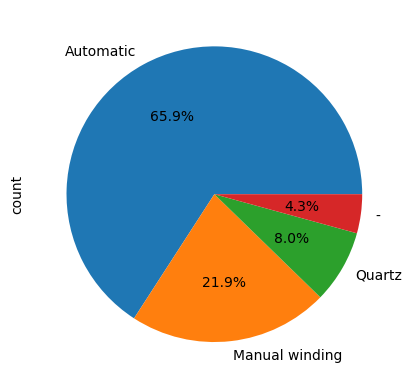

In [10]:
# Vẽ biểu đồ tròn thể hiện phần trăm tỉ lệ giữa các giá trị
data['Movement'].value_counts().plot.pie(autopct='%.1f%%')

Ta sử dụng kĩ thuật điền vào những ô bị trống dữ liệu bằng random mang những giá trị hợp lệ tồn tại trong dataset với xác suất là tỉ lệ những giá trị có mặt trong dataset.

Thử với cột "Movement":

In [11]:
# Tính phần trăm tỉ lệ xuất hiện của các giá trị hợp lệ trong cột "Movement"
valid_values = data[data['Movement'] != '-']['Movement']
proportions = valid_values.value_counts(normalize=True)


# Lấy danh sách các giá trị hợp lệ
valid_values_list = proportions.index.tolist()

# Thay thế các giá trị "-" bằng các giá trị mới dựa trên phần trăm tỉ lệ xuất hiện của các giá trị hợp lệ
num_replacements = (data['Movement'] == '-').sum()
new_values = np.random.choice(valid_values_list, size=num_replacements, p=proportions)
data.loc[data['Movement'] == '-', 'Movement'] = new_values

# Kiểm tra kết quả
print(data['Movement'].value_counts())


Movement
Automatic         6029
Manual winding    1998
Quartz             728
Name: count, dtype: int64


Làm tương tự với những cột còn lại.

In [12]:
print(data['Case material'].value_counts())

Case material
White gold     2198
Rose gold      2101
Steel          1882
Yellow gold    1442
Platinum        571
-               397
Gold/Steel      112
Red gold         41
Silver            6
Aluminum          3
Palladium         2
Name: count, dtype: int64


In [13]:

valid_values_case_material = data[data['Case material'] != '-']['Case material']
proportions_case_material = valid_values_case_material.value_counts(normalize=True)

valid_values_list_case_material = proportions_case_material.index.tolist()

num_replacements_case_material = (data['Case material'] == '-').sum()
new_values_case_material = np.random.choice(valid_values_list_case_material, size=num_replacements_case_material, p=proportions_case_material)
data.loc[data['Case material'] == '-', 'Case material'] = new_values_case_material

print(data['Case material'].value_counts())


Case material
White gold     2295
Rose gold      2191
Steel          1971
Yellow gold    1518
Platinum        611
Gold/Steel      117
Red gold         41
Silver            6
Aluminum          3
Palladium         2
Name: count, dtype: int64


In [14]:
print(data['Year of production'].value_counts())

Year of production
-       2817
2023     756
2022     689
2024     506
2021     455
        ... 
1870       1
1922       1
1919       1
1912       1
1888       1
Name: count, Length: 136, dtype: int64


In [15]:
valid_values_year_of_production = data[data['Year of production'] != '-']['Year of production']
proportions_year_of_production = valid_values_year_of_production.value_counts(normalize=True)

valid_values_list_year_of_production = proportions_year_of_production.index.tolist()

num_replacements_year_of_production = (data['Year of production'] == '-').sum()
new_values_year_of_production = np.random.choice(valid_values_list_year_of_production, size=num_replacements_year_of_production, p=proportions_year_of_production)
data.loc[data['Year of production'] == '-', 'Year of production'] = new_values_year_of_production

print(data['Year of production'].value_counts())


Year of production
2023    1132
2022    1019
2024     730
2021     672
2020     447
        ... 
1922       1
1870       1
1912       1
1936       1
1888       1
Name: count, Length: 135, dtype: int64


In [16]:
data['Year of production'] = data['Year of production'].astype(int)

In [17]:
print(data['Condition'].value_counts())


Condition
Very good     4385
New           1728
Unworn        1698
Good           721
Fair           136
-               86
Incomplete       1
Name: count, dtype: int64


In [18]:
valid_values_condition = data[data['Condition'] != '-']['Condition']
proportions_condition = valid_values_condition.value_counts(normalize=True)

valid_values_list_condition = proportions_condition.index.tolist()

num_replacements_condition = (data['Condition'] == '-').sum()
new_values_condition = np.random.choice(valid_values_list_condition, size=num_replacements_condition, p=proportions_condition)
data.loc[data['Condition'] == '-', 'Condition'] = new_values_condition

print(data['Condition'].value_counts())


Condition
Very good     4430
New           1745
Unworn        1714
Good           728
Fair           137
Incomplete       1
Name: count, dtype: int64


In [19]:

print(data['Reference number'].value_counts())


Reference number
-                                     245
5712/1A-001                           122
5711/1A-010                            92
5167A-001                              90
5167R-001                              82
                                     ... 
3344 patek                              1
ref.96 Yellow Antimagnetic              1
5117R                                   1
Patek Philippe Gondolo 4868/1R-010      1
3542                                    1
Name: count, Length: 1806, dtype: int64


In [20]:

valid_values_reference_number = data[data['Reference number'] != '-']['Reference number']
proportions_reference_number = valid_values_reference_number.value_counts(normalize=True)

valid_values_list_reference_number = proportions_reference_number.index.tolist()

num_replacements_reference_number = (data['Reference number'] == '-').sum()
new_values_reference_number = np.random.choice(valid_values_list_reference_number, size=num_replacements_reference_number, p=proportions_reference_number)
data.loc[data['Reference number'] == '-', 'Reference number'] = new_values_reference_number

print(data['Reference number'].value_counts())

Reference number
5712/1A-001                            131
5711/1A-010                             95
5167A-001                               94
5980/1R-001                             83
5167R-001                               82
                                      ... 
5117R                                    1
Patek Philippe Gondolo 4868/1R-010       1
Patek Philippe Nautilus 3712/1A-001      1
3883                                     1
3542                                     1
Name: count, Length: 1805, dtype: int64


In [21]:
print(data['Scope of delivery'].value_counts())

Scope of delivery
Original box, original papers          6104
No original box, no original papers    1661
Original box, no original papers        521
Original papers, no original box        469
Name: count, dtype: int64


In [22]:
valid_values_scope_of_delivery = data[data['Scope of delivery'] != '-']['Scope of delivery']
proportions_scope_of_delivery = valid_values_scope_of_delivery.value_counts(normalize=True)

valid_values_list_scope_of_delivery = proportions_scope_of_delivery.index.tolist()

num_replacements_scope_of_delivery = (data['Scope of delivery'] == '-').sum()
new_values_scope_of_delivery = np.random.choice(valid_values_list_scope_of_delivery, size=num_replacements_scope_of_delivery, p=proportions_scope_of_delivery)
data.loc[data['Scope of delivery'] == '-', 'Scope of delivery'] = new_values_scope_of_delivery

print(data['Scope of delivery'].value_counts())

Scope of delivery
Original box, original papers          6104
No original box, no original papers    1661
Original box, no original papers        521
Original papers, no original box        469
Name: count, dtype: int64


In [23]:
print(data['Case area(mm2)'].value_counts())

Case area(mm2)
1256.637061    1124
-               685
1288.249338     575
1075.210086     455
1194.590607     429
               ... 
868.0             1
1526.0            1
1184.0            1
2000.0            1
651.0             1
Name: count, Length: 370, dtype: int64


In [24]:
valid_values_case_area = data[data['Case area(mm2)'] != '-']['Case area(mm2)']
proportions_case_area = valid_values_case_area.value_counts(normalize=True)

valid_values_list_case_area = proportions_case_area.index.tolist()

num_replacements_case_area = (data['Case area(mm2)'] == '-').sum()
new_values_case_area = np.random.choice(valid_values_list_case_area, size=num_replacements_case_area, p=proportions_case_area)
data.loc[data['Case area(mm2)'] == '-', 'Case area(mm2)'] = new_values_case_area

print(data['Case area(mm2)'].value_counts())


Case area(mm2)
1256.637061    1225
1288.249338     633
1075.210086     490
1194.590607     466
1017.876020     442
               ... 
150.000000        1
877.500000        1
405.000000        1
868.000000        1
651.000000        1
Name: count, Length: 369, dtype: int64


In [25]:
print(data['Location'].value_counts())


Location
United States of America, New York, New York        1239
United Kingdom, London                               356
UAE, Dubai                                           256
Spain, Madrid                                        222
United States of America, Florida, Miami             221
                                                    ... 
Australia, 2063                                        1
United States of America, Iowa, Des Moines             1
United States of America, Massachusetts, Andover       1
United States of America, New York                     1
Italy, GENOVA                                          1
Name: count, Length: 867, dtype: int64


Riêng trong cột "Location" và "Case area(mm2)" thì không cần xử lý những giá trị thiếu.

In [26]:
num_dashes = (data['Location'] == '').sum()

print("Số lượng giá trị '-' trong cột Location là:", num_dashes)


Số lượng giá trị '-' trong cột Location là: 0


In [27]:
total_rows = data.shape[0]
print("Tổng số hàng trong dataset là:", total_rows)

Tổng số hàng trong dataset là: 8755


Thực hiện rà soát lại lần cuối những giá trị không hợp lệ để làm sạch data.

In [28]:
# name,Movement,Case material,Year of production,Condition,Reference number,Scope of delivery,Location,Case diameter,price
# Bỏ đi những hàng bị trống dữ liệu hoặc dữ liệu không hợp lệ như '-', 'NaN', 'None', 'N/A', 'na', 'n/a', 'null', 'NULL', 'nil', 'NIL', ''
data = data[~data['Movement'].isin(empty_strings)]
data = data[~data['Case area(mm2)'].isin(empty_strings)]
data = data[~data['Year of production'].isin(empty_strings)]
data = data[~data['Condition'].isin(empty_strings)]
data = data[~data['Reference number'].isin(empty_strings)]
data = data[~data['Scope of delivery'].isin(empty_strings)]
data = data[~data['Location'].isin(empty_strings)]

# Số hàng trong dataset sau khi loại bỏ các hàng bị trống dữ liệu
total_rows_cleaned = data.shape[0]
print("Tổng số hàng trong dataset sau khi loại bỏ các hàng bị trống dữ liệu là:", total_rows_cleaned)

# Tính tỉ lệ phần trăm số hàng bị loại bỏ so với tổng số hàng
ratio_removed_rows = (total_rows - total_rows_cleaned) / total_rows * 100
print("Tỉ lệ phần trăm số hàng bị loại bỏ so với tổng số hàng là:", ratio_removed_rows, "%")




Tổng số hàng trong dataset sau khi loại bỏ các hàng bị trống dữ liệu là: 8755
Tỉ lệ phần trăm số hàng bị loại bỏ so với tổng số hàng là: 0.0 %


In [29]:
data.head(35)

,name,Movement,Case material,Year of production,Condition,Reference number,Scope of delivery,Location,Case area(mm2),price($)
0,Patek Philippe Gondolo,Manual winding,Yellow gold,2010,Very good,5109J-001,"Original box, original papers","Germany, Düsseldorf",706.858347,12238.0
1,Patek Philippe Nautilus,Automatic,Steel,2020,New,7118/1200A-011,"Original box, original papers","United States of America, New York, New York",973.13974,81860.0
2,Patek Philippe Perpetual Calendar,Automatic,White gold,2023,New,5236P,"Original box, original papers","United States of America, Florida, North Miami...",1339.645793,121745.0
3,Patek Philippe Annual Calendar Chronograph,Automatic,White gold,2020,Unworn,5960/01G-001,"Original box, original papers","United States of America, New York, New York",1288.249338,61445.0
5,Patek Philippe Calatrava,Automatic,White gold,2024,Very good,5117G,"Original box, no original papers","Czech Republic, Praha 1",1075.210086,21046.0
6,Patek Philippe Perpetual Calendar Chronograph,Manual winding,Rose gold,2022,Unworn,5204R-011,"Original box, original papers","Germany, Köln",1256.637061,300650.0
7,Patek Philippe Gondolo,Automatic,Rose gold,1952,Very good,4962/200R,"Original box, original papers","Czech Republic, Praha 1",1134.114948,54008.0
8,Patek Philippe Annual Calendar Chronograph,Automatic,Rose gold,2022,New,5905R-001,"Original box, original papers","United States of America, New York, New York",1385.44236,99999.0
10,Patek Philippe Calatrava,Automatic,Yellow gold,1965,Very good,3445-6,"No original box, no original papers","Switzerland, Lugano",962.11275,10214.0
11,Patek Philippe Nautilus,Automatic,Rose gold,2016,Very good,5711/1R-001,"Original box, original papers","United Kingdom, London",1256.637061,215048.0


In [30]:
print(data['Case material'].value_counts())

Case material
White gold     2295
Rose gold      2191
Steel          1971
Yellow gold    1518
Platinum        611
Gold/Steel      117
Red gold         41
Silver            6
Aluminum          3
Palladium         2
Name: count, dtype: int64


In [31]:
# Chỉ lấy price$ < 175000
# data = data[data['price($)'] < 170000]


In [32]:
# Tại cột 'Reference number' hãy xử lý những giá trị có 4 kí tự đầu giống nhau thì gộp lại thành 1 nhóm

data['Reference number'] = data['Reference number'].str[:4]

print(data['Reference number'].value_counts())


Reference number
5980    322
5712    313
5711    312
5167    272
7118    260
       ... 
Einm      1
5108      1
3036      1
4179      1
3542      1
Name: count, Length: 641, dtype: int64


In [33]:
# # Tại cột 'location' chỉ lấy giá trị sau dấu ',' đầu tiên và kết thúc bởi ',' thứ 2
# data['Location'] = data['Location'].str.split(',').str[1]

# print(data['Location'].value_counts())

In [34]:
print(data['Case material'].value_counts())

Case material
White gold     2295
Rose gold      2191
Steel          1971
Yellow gold    1518
Platinum        611
Gold/Steel      117
Red gold         41
Silver            6
Aluminum          3
Palladium         2
Name: count, dtype: int64


In [35]:
# Xóa các hàng nếu giá trị tại cột "Case material" có giá trị 'Aluminum' và 'Palladium'ArithmeticError
data = data[~data['Case material'].isin(['Aluminum', 'Palladium'])]



In [36]:
# Mã hóa các dặc trưng bằng kĩ thuật Label Encoding
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
categorical_columns = ['name', 'Movement', 'Case material', 'Condition', 'Reference number', 'Scope of delivery', 'Location']

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

data.head(10)


,name,Movement,Case material,Year of production,Condition,Reference number,Scope of delivery,Location,Case area(mm2),price($)
0,12,1,7,2010,5,433,2,164,706.858347,12238.0
1,17,0,5,2020,3,577,2,824,973.13974,81860.0
2,20,0,6,2023,3,483,2,747,1339.645793,121745.0
3,2,0,6,2020,4,545,2,824,1288.249338,61445.0
5,6,0,6,2024,5,439,1,85,1075.210086,21046.0
6,21,1,3,2022,4,470,2,195,1256.637061,300650.0
7,12,0,3,1952,5,360,2,85,1134.114948,54008.0
8,2,0,3,2022,3,538,2,824,1385.44236,99999.0
10,6,0,7,1965,5,132,0,554,962.11275,10214.0
11,17,0,3,2016,5,525,2,645,1256.637061,215048.0


Thực hiện ghi vào file "clean_data.csv"

In [37]:
data.to_csv('C:\KHDL_CK\Data\patekphilippe_clean_data_pure_train.csv', index=False)